# POLI 175 - Lecture 08

## Classification

## Classification

Loading packages:

In [1]:
# If needed
using Pkg
Pkg.add("Missings")
Pkg.add("StatsAPI")
Pkg.add("FreqTables")
Pkg.add("EvalMetrics")
Pkg.update()

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


## Classification

Loading packages:

In [2]:
## Loading the packages
using CSV, DataFrames, Plots, GLM, StatsBase, Random
using LaTeXStrings, StatsPlots, Lowess, Gadfly, RegressionTables
using CovarianceMatrices, Econometrics, LinearAlgebra, MixedModelsExtras
using Missings, StatsAPI, FreqTables, EvalMetrics

# Auxiliar function
function pairplot(df)
    _, cols = size(df)
    plots = []
    for row = 1:cols, col = 1:cols
        push!(
            plots,
            scatter(
                df[:, row],
                df[:, col],
                xtickfont = font(4),
                ytickfont = font(4),
                legend = false,
            ),
        )
    end
    Plots.plot(plots..., layout = (cols, cols))
end

pairplot (generic function with 1 method)

# Classification

## Classification

Linear regression is great! But it assumes we want to predict a continuous target variable.

There are situations when our target is qualitative.

**Examples:**

1. Whether a country default its debt obligations?

1. Whether a person voted Republican, Democrat, Independent, voted for a different party, or did not turnout to vote?

1. What determines the number of FOI requests that a given public office receives every day?

1. Is a country expected to meet, exceed, or not meet the Paris Treaty Nationally Determined Contributions?

All these questions are qualitative in nature.

## Running Example

### [Chile Survey](https://en.wikipedia.org/wiki/Chile)

In 1988, the [Chilean Dictator](https://en.wikipedia.org/wiki/Military_dictatorship_of_Chile) [Augusto Pinochet](https://en.wikipedia.org/wiki/Augusto_Pinochet) conducted a [referendum to whether he should step out](https://en.wikipedia.org/wiki/1988_Chilean_presidential_referendum).

The [FLACSO](https://en.wikipedia.org/wiki/Latin_American_Faculty_of_Social_Sciences) in Chile conducted a surver on 2700 respondents. We are going to build a model to predict their voting intentions.

| **Variable** | **Meaning** |
|:---:|---|
| region | A factor with levels:<br>- `C`, Central; <br>- `M`, Metropolitan Santiago area; <br>- `N`, North; <br>- `S`, South; <br>- `SA`, city of Santiago. |
| population | The population size of respondent's community. |
| sex | A factor with levels: <br>- `F`, female; <br>- `M`, male. |
| age | The respondent's age in years. |
| education | A factor with levels: <br>- `P`, Primary; <br>- `S`, Secondary; <br>- `PS`, Post-secondary. |
| income | The respondent's monthly income, in Pesos. |
| statusquo | A scale of support for the status-quo. |
| vote | A factor with levels: <br>- `A`, will abstain; <br>- `N`, will vote no (against Pinochet);<br>- `U`, is undecided; <br>- `Y`, will vote yes (for Pinochet). |

## Chile Survey

In [3]:
## Loading the data
chile = CSV.read(
    download("https://raw.githubusercontent.com/umbertomig/POLI175julia/main/data/chilesurvey.csv"), 
    DataFrame,
    missingstring = ["NA"]
); dropmissing!(chile)
chile.voteyes = ifelse.(chile.vote .== "Y", 1, 0)
first(chile, 3)

3×9 DataFrame
 Row │ region   population  sex      age    education  income  statusquo  vote ⋯
     │ String3  Int64       String1  Int64  String3    Int64   Float64    Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ N            175000  M           65  P           35000    1.0082   Y    ⋯
   2 │ N            175000  M           29  PS           7500   -1.29617  N
   3 │ N            175000  F           38  P           15000    1.23072  Y
                                                               2 columns omitted

## Book's Example

Probability of voting `yes` (favor of Pinochet remain in power for eight more years), conditional on how satisfied the person is with things as they are:

In [4]:
dat = DataFrame(statusquo = collect(range(-3, stop = 3, length = 100)));

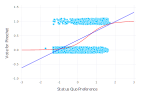

In [5]:
Gadfly.plot(
    x = chile.statusquo, y = chile.voteyes, Stat.y_jitter(range = 0.2), Geom.point,
    Guide.xlabel("Status Quo Preference"), Guide.ylabel("Vote for Pinochet"),
    layer(x = dat.statusquo, y = predict(glm(@formula(voteyes ~ statusquo), chile, Binomial(), LogitLink()), dat), Geom.line, color = [colorant"red"], order = 2),
    layer(x = dat.statusquo, y = predict(lm(@formula(voteyes ~ statusquo), chile), dat), Geom.line, color = [colorant"blue"], order = 3)
)

## Logistic Regression

[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) belongs to a class of models called [Generalized Linear Models](https://en.wikipedia.org/wiki/Generalized_linear_model) (or GLM for short).

GLM, in a nutshell (and in a proudly lazy definition) is an expansion of Linear Model that assumes:
- A Linear Relationship in part of the model
- But then applies a non-linear transformation to the response variable.

The non-linear transformation is called `link function`. Many link functions around (check [here](https://en.wikipedia.org/wiki/Generalized_linear_model) for various link functions).

The link function will determine which types of models we run.

When the outcome variable is binary, we may use `Logistic` or `Probit` links.

## Logistic Regression

In a regression, we are investigating something along the lines of:

$$ \mathbb{E}[Y | X] \ = \ \beta_0 + \beta_1 X $$

But when the outcome is binary we would like to get:

$$ \mathbb{E}[Y | X] \ = \ \mathbb{P}(Y = 1 | X) $$

And the Logistic link is nothing but:

$$ \mathbb{P}(Y = 1 | X) \ = \ \dfrac{e^{(\beta_0 + \beta_1X)}}{1 + e^{(\beta_0 + \beta_1X)}} \ = \ \dfrac{1}{1 + e^{-(\beta_0 + \beta_1X)}} $$

## Logistic Regression

With a bit of manipulation, we get to something called odds ratio:

$$ \dfrac{\mathbb{P}(Y = 1 | X)}{\mathbb{P}(Y = 0 | X)} \ = \ \dfrac{\mathbb{P}(Y = 1 | X)}{1 - \mathbb{P}(Y = 1 | X)} \ = \ e^{(\beta_0 + \beta_1X)} $$

And logging the thing gets rid of the Euler constant:

$$ \log \left( \dfrac{\mathbb{P}(Y = 1 | X)}{1 - \mathbb{P}(Y = 1 | X)}\right) \ = \ \beta_0 + \beta_1X $$

And this is the [Logit Link](https://en.wikipedia.org/wiki/Logistic_regression).

## Logistic Regression

Little detour to talk about odd ratios:

- Note the odd ratio: $\dfrac{\mathbb{P}(Y = 1 | X)}{1 - \mathbb{P}(Y = 1 | X)}$

- It is a ratio between the chance of $Y = 1$ divided by the chance of $Y = 0$.

- Since probabilities are between zero and one, the ratio is always between $(0, \infty)$.

Example:

- If based on characteristics, two in every ten people vote for Pinochet, $\mathbb{P}(Y = 1 | X = \text{some characs.}) = 0.2$ and the odds ratio is $1/4$.

- If based on other set of characteristics, nine out of ten people vote for Pinochet, $\mathbb{P}(Y = 1 | X = \text{some other characs.}) = 0.9$ and the odds ratio is $9$.

One is the number that *does not change the ratios*.


## Logistic Regression

Little other detour to talk about the coefficients:

In linear regression, changes in one unit of $x_i$ changes your target variable in $\beta_i$ units, on average.

In logistic regression, changes in one unit of $x_i$ changes **the log odds** of your target variable in $\beta_i$ units, on average.

- Multiplies the odds by $e^{\beta_i}$! This is **not** a straight line!

- Easy proxy (does not work for interaction terms): 
    + When $\beta_1$ is **positive**, it **increases** the $\mathbb{P}(Y = 1 | X)$
    + When $\beta_1$ is **negative**, it **decreases** the $\mathbb{P}(Y = 1 | X)$
    
Try to compute the partial derivatives on $X$ and you will see the complications!

## Logistic Regression

Technical:

1. The estimation is through [maximizing the likelihood function](https://en.wikipedia.org/wiki/Likelihood_function).<br> This is outside the scope of the course, but an interesting topic to learn in an advanced course.<br> <br> 


2. The hypothesis test for the coefficient's significance in here is a Z-test (based on the Normal distribution). <br> Null Hypothesis: $$H_0: \beta_i = 0 \quad \text{ or alternatively, } \quad H_0: e^{\beta_i} = 1$$<br> <br> 


3. Making predictions: Just insert the predicted $\hat{\beta}$s on the equation.
    
$$ \hat{p}(X) \ = \ \dfrac{e^{\hat{\beta}_0 + \hat{\beta}_1 X}}{1 + e^{\hat{\beta}_0 + \hat{\beta}_1 X}} $$

## Logistic Regression

Fitting a Linear Regression using Julia GLM package. Note the syntax:

```julia
glm(
    @formula(target ~ feature1 + feature2 + ... + featureK), 
    dataset, 
    distr = Binomial(),
    link = LogitLink()
)
```

In [6]:
modlog = glm(@formula(voteyes ~ age), chile, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

voteyes ~ 1 + age

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -1.16686    0.121266    -9.62    <1e-21  -1.40454     -0.929182
age           0.0134508  0.00289826   4.64    <1e-05   0.00777034   0.0191313
─────────────────────────────────────────────────────────────────────────────

What is happening here? Let us interpret some of the results.

## Logistic Regression

Compare with a linear regression:

In [7]:
# Linear Model
modlin = lm(@formula(voteyes ~ age), chile)
regtable(modlin, modlog)


----------------------------------
                     voteyes      
              --------------------
                   (1)         (2)
----------------------------------
(Intercept)   0.227***   -1.167***
               (0.027)     (0.121)
age           0.003***    0.013***
               (0.001)     (0.003)
----------------------------------
Estimator          OLS          NL
----------------------------------
N                2,431       2,431
R2               0.009            
----------------------------------




What is happening here? Let us interpret some of the results for both models.

## Logistic Regression

Column 1: [Linear Probability Model](https://en.wikipedia.org/wiki/Linear_probability_model)

Column 2: [Logistic Model](https://en.wikipedia.org/wiki/Logistic_regression)

Column 3: [Probit Model](https://en.wikipedia.org/wiki/Probit_model)

And there are other links that we may use.

In [8]:
modpro = glm(@formula(voteyes ~ age), chile, Binomial(), ProbitLink())
regtable(modlin, modlog, modpro)


----------------------------------------------
                           voteyes            
              --------------------------------
                   (1)         (2)         (3)
----------------------------------------------
(Intercept)   0.227***   -1.167***   -0.721***
               (0.027)     (0.121)     (0.074)
age           0.003***    0.013***    0.008***
               (0.001)     (0.003)     (0.002)
----------------------------------------------
Estimator          OLS          NL          NL
----------------------------------------------
N                2,431       2,431       2,431
R2               0.009                        
----------------------------------------------




## Logistic Regression

We can easily fit multivariate regressions:

Model 1: [Linear Probability Model](https://en.wikipedia.org/wiki/Linear_probability_model)

Model 2: [Logistic Model](https://en.wikipedia.org/wiki/Logistic_regression)

Model 3: [Probit Model](https://en.wikipedia.org/wiki/Probit_model)

In [9]:
modlin2 = lm(@formula(voteyes ~ region + log(population) + sex + age + education + log(income)), chile);
modlog2 = glm(@formula(voteyes ~ region + log(population) + sex + age + education + log(income)), chile, Binomial(), LogitLink());
modpro2 = glm(@formula(voteyes ~ region + log(population) + sex + age + education + log(income)), chile, Binomial(), ProbitLink());

## Logistic Regression

Now with a pretty table:

In [10]:
regtable(modlin2, modlog2, modpro2; 
    groups = ["Linear", "Logistic", "Probit"],
    number_regressions = false,
    labels = Dict("voteyes" => "Vote for Pinochet", "(Intercept)" => "Constant", "region: M" => "Region = Santiago Metro",
        "region: N" => "Region = North", "region: S" => "Region = South", 
        "region: SA" => "Region = Santiago City", "log(population)" => "Log District Population",
        "sex: M" => "Male", "age" => "Age", "education: PS" => "Post-Secondary Education",
        "education: S" => "Secondary Education", "log(income)" => "Log District Income"
    )
)


------------------------------------------------------------
                             Linear     Logistic     Probit 
                           ---------   ---------   ---------
                                   Vote for Pinochet        
                           ---------------------------------
Constant                       0.258      -1.178      -0.716
                             (0.150)     (0.690)     (0.422)
Region = Santiago Metro      0.154**     0.671**     0.413**
                             (0.057)     (0.255)     (0.158)
Region = North              0.139***    0.626***    0.379***
                             (0.033)     (0.153)     (0.093)
Region = South              0.104***    0.474***    0.289***
                             (0.027)     (0.125)     (0.076)
Region = Santiago City         0.032       0.137       0.084
                             (0.029)     (0.142)     (0.085)
Log District Population    -0.046***   -0.207***   -0.127***
                       

## Logistic Regression

The predicted values are probabilities:

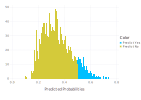

In [11]:
Gadfly.plot(
    x = predict(modlog2), 
    Geom.histogram, 
    color = ifelse.(predict(modlog2).>0.5, "Predict Yes", "Predict No"),
    Guide.xlabel("Predicted Probabilities")
)

## Logistic Regression

Let's look at the coefficients. Those are log odds ratio:

In [12]:
## Parameters
println(modlog2)
println(coef(modlog2))

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

voteyes ~ 1 + region + :(log(population)) + sex + age + education + :(log(income))

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                      Coef.  Std. Error      z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)      -1.17825    0.690214    -1.71    0.0878  -2.53104      0.174544
region: M         0.671045   0.2548       2.63    0.0084   0.171647     1.17044
region: N         0.626152   0.152614     4.10    <1e-04   0.327034     0.925271
region: S         0.474237   0.125468     3.78    0.0002   0.228325     0.720149
region: SA        0.13699    0.142186     0.96    0.3353  -0.141689     0.415669
log(population)  -0.206985   0.

## Logistic Regression

To make them odds ratio, we exponentiate.

In [13]:
## Parameters
println(modlog2)
println(exp.(coef(modlog2)))

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

voteyes ~ 1 + region + :(log(population)) + sex + age + education + :(log(income))

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                      Coef.  Std. Error      z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)      -1.17825    0.690214    -1.71    0.0878  -2.53104      0.174544
region: M         0.671045   0.2548       2.63    0.0084   0.171647     1.17044
region: N         0.626152   0.152614     4.10    <1e-04   0.327034     0.925271
region: S         0.474237   0.125468     3.78    0.0002   0.228325     0.720149
region: SA        0.13699    0.142186     0.96    0.3353  -0.141689     0.415669
log(population)  -0.206985   0.

## Logistic Regression

**The interaction term**: 

We found in the previous models that:

1. The higher the district's population, the lower the chance of supporting Pinochet
1. The higher the district's income, the higher the chance of voting for Pinochet

The first result relates with people living in cities preferring democracy; the second results relate to people that are benefiting financially from the status quo preferring to keep things as they are.

But how about a rich person that lives in a city? In the US analogy, thing of billionaire democrat. She supports the democrats even though she may be benefiting from things they are.

Conversely, how about a poor person that lives in a village? It could be that the person is not benefiting from things they are, but she favors Pinochet for conservative issues.

Let us prepare a situation where population stays fixed on one of three values: 25th percentile (small villages), median (median-density districts), 75th percentile (more dense districts); and income varying from zero to one million pesos.

This should give an idea of how population and income jointly affect the probability of voting for Pinochet.

In [14]:
# Auxiliary variables
chile.pop100k = chile.population / 100000;
chile.inc1mi = chile.income / 1000000;

In [15]:
# Three interactions between a fixed income and a varying population
newdat_popq1 = DataFrame(
    pop100k = repeat([quantile(chile.pop100k, 0.25)], 100), 
    inc1mi = collect(range(0.0, stop = 1.0, length = 100))
);
newdat_popmed = DataFrame(
    pop100k = repeat([median(chile.pop100k)], 100), 
    inc1mi = collect(range(0.0, stop = 1.0, length = 100))
);
newdat_popq3 = DataFrame(
    pop100k = repeat([quantile(chile.pop100k, 0.75)], 100), 
    inc1mi = collect(range(0.0, stop = 1.0, length = 100))
);

## Logistic Regression

**The interaction term**: 

In a linear regression:

In [16]:
## Parameters
modlin3 = lm(@formula(voteyes ~ pop100k * inc1mi ), chile)
regtable(modlin3; 
    number_regressions = false,
    labels = Dict(
        "voteyes" => "Vote for Pinochet", 
        "(Intercept)" => "Constant", 
        "pop100k" => "Population (100k people)",
        "inc1mi" => "Income (1 million pesos)",
        "pop100k & inc1mi" => "Population x Income"
    )
)


--------------------------------------------
                           Vote for Pinochet
                           -----------------
Constant                            0.460***
                                     (0.023)
Population (100k people)           -0.095***
                                     (0.013)
Income (1 million pesos)              -0.451
                                     (0.653)
Population x Income                   0.714*
                                     (0.299)
--------------------------------------------
Estimator                                OLS
--------------------------------------------
N                                      2,431
R2                                     0.030
--------------------------------------------




## Logistic Regression

**The interaction term**:

And here is how the interaction term affects the results:

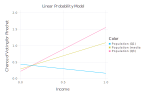

In [17]:
Gadfly.plot(x = newdat_popq1.inc1mi, y=predict(modlin3, newdat_popq1), Geom.line, color = ["Population (Q1)"],
    layer(x = newdat_popmed.inc1mi, y=predict(modlin3, newdat_popmed), Geom.line, color = ["Population (median)"]),
    layer(x = newdat_popq3.inc1mi, y=predict(modlin3, newdat_popq3), Geom.line, color = ["Population (Q3)"]),
    Guide.xlabel("Income"),
    Guide.ylabel("Chance of Voting for Pinochet"),
    Guide.title("Linear Probability Model") 
)

Note the ***linearity*** of the interaction effect. Note also the effects of extrapolating.

## Logistic Regression

**The interaction term**: 

In the logistic regression, you need to use a plot called [interactive effects plot](). If you are curious, [here is a good theoretical explanation, with Stata examples](https://stats.oarc.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/).

In [18]:
## Parameters
modlog3 = glm(@formula(voteyes ~ pop100k * inc1mi), chile, Binomial(), LogitLink())
regtable(modlog3; 
    number_regressions = false,
    labels = Dict(
        "voteyes" => "Vote for Pinochet", 
        "(Intercept)" => "Constant", 
        "pop100k" => "Population (100k people)",
        "inc1mi" => "Income (1 million pesos)",
        "pop100k & inc1mi" => "Population x Income"
    )
)


--------------------------------------------
                           Vote for Pinochet
                           -----------------
Constant                              -0.145
                                     (0.100)
Population (100k people)           -0.429***
                                     (0.057)
Income (1 million pesos)              -1.901
                                     (2.842)
Population x Income                   3.167*
                                     (1.307)
--------------------------------------------
Estimator                                 NL
--------------------------------------------
N                                      2,431
R2                                          
--------------------------------------------




## Logistic Regression

**The interaction term**:

Note now the ***non-linearity*** of the interaction effect:

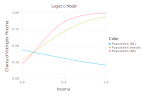

In [19]:
Gadfly.plot(x = newdat_popq1.inc1mi, y=predict(modlog3, newdat_popq1), Geom.line, color = ["Population (Q1)"],
    layer(x = newdat_popmed.inc1mi, y=predict(modlog3, newdat_popmed), Geom.line, color = ["Population (median)"]),
    layer(x = newdat_popq3.inc1mi, y=predict(modlog3, newdat_popq3), Geom.line, color = ["Population (Q3)"]),
    Guide.xlabel("Income"),
    Guide.ylabel("Chance of Voting for Pinochet"),
    Guide.title("Logistic Model") 
)

## Logistic Regression

In generalized linear models where the link function is not the identity function (i.e., not a linear regression), you need to be careful when interpreting and using interactions.

In linear models, it is straightforward.

In all models, it involves taking a partial derivative of the conditional expectation function that we fit in the training stage.

A catch is: This discussion matters more if you care about interpreting your model. For prediction, it does not matter that much.

***But what matters for prediction?***

## Logistic Regression

### Prediction

Suppose that we are an investment firm that will invest in Chile only if democracy wins.

Because the plebiscite did not happened, uncertainty may bring its own gains. Thus, it may be better to invest *before* the results.

All we have is this dataset. So, how much we predict modeling the vote for pinochet using these variables?

Let us model vote for Pinochet using the following variables: `log(income)`, `log(population)`, and `age`.

In [20]:
modlog4 = glm(@formula(voteyes ~ log(population) + log(income) + age), chile, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

voteyes ~ 1 + :(log(population)) + :(log(income)) + age

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                      Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)       0.53344    0.549433     0.97    0.3316  -0.543429    1.61031
log(population)  -0.269728   0.0383962   -7.02    <1e-11  -0.344983   -0.194473
log(income)       0.136022   0.0447885    3.04    0.0024   0.0482384   0.223806
age               0.0142287  0.00294087   4.84    <1e-05   0.0084647   0.0199927
────────────────────────────────────────────────────────────────────────────────

How well is this model doing?

## Logistic Regression

### Prediction

We have significance, and we may think: pretty well! But like the $R^2$ for linear regressions, we need something that works similar in here.

Let us start checking how people voted:

In [21]:
freqtable(chile.voteyes)

2-element Named Vector{Int64}
Dim1  │ 
──────┼─────
0     │ 1595
1     │  836

In [22]:
proptable(chile.voteyes)

2-element Named Vector{Float64}
Dim1  │ 
──────┼─────────
0     │ 0.656109
1     │ 0.343891

And if you were to guess, what would that guess be? ***This is our benchmark!***

## Logistic Regression

### Prediction

Now let us look at our model. 

For simplicity, we will say that if the model gives more than 0.5 chance of favoring Pinochet, the person voted in favor. Otherwise, the person voted against.

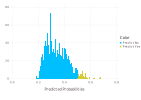

In [23]:
Gadfly.plot(
    x = predict(modlog4), 
    Geom.histogram, 
    color = ifelse.(predict(modlog4).>0.5, "Predict Yes", "Predict No"),
    Guide.xlabel("Predicted Probabilities")
)

## Logistic Regression

### Prediction

Now let us look at our model. 

For simplicity, we will say that if the model gives more than 0.5 chance of favoring Pinochet, the person voted in favor. Otherwise, the person voted against.

In [24]:
predicted_vote = ifelse.(predict(modlog4) .> 0.5, 1, 0);

In [25]:
freqtable(predicted_vote)

2-element Named Vector{Int64}
Dim1  │ 
──────┼─────
0     │ 2315
1     │  116

In [26]:
proptable(predicted_vote)

2-element Named Vector{Float64}
Dim1  │ 
──────┼─────────
0     │ 0.952283
1     │ 0.047717

Are we doing better than chance? How can we know that?

## Logistic Regression

### Prediction

[**Confusion Matrix**](https://en.wikipedia.org/wiki/Confusion_matrix)

A confusion matrix is simply a display of the ground truth (rows) x the model's prediction (columns).

![confm](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/confm_wikipedia.png?raw=true)

In [27]:
freqtable(chile.voteyes, predicted_vote)

2×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │    0     1
────────────┼───────────
0           │ 1536    59
1           │  779    57

### Prediction

[**Confusion Matrix**](https://en.wikipedia.org/wiki/Confusion_matrix)

|  | **Predicted: 0** | **Predicted: 1** |
|---|---|---|
| **Actual: 0** | True Negative (tn) | False Positive (fp) |
| **Actual: 1** | False Negative (fn) | True Positive (tp) |

[**Accuracy:**](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers) $$\dfrac{\text{correct predictions}}{\text{total observations}} \ = \ \dfrac{tp + tn}{tp + tn + fp + fn}$$

- High accuracy: lots of correct predictions!

### Measuring Performance

[**Confusion Matrix**](https://en.wikipedia.org/wiki/Confusion_matrix)

|  | **Predicted: 0** | **Predicted: 1** |
|---|---|---|
| **Actual: 0** | True Negative (tn) | False Positive (fp) |
| **Actual: 1** | False Negative (fn) | True Positive (tp) |

[**Precision**](https://en.wikipedia.org/wiki/Precision_and_recall): $$\dfrac{\text{true positives}}{\text{total predicted positive}} \ = \ \dfrac{tp}{tp + fp}$$

- High precision: low false-positive rates.


### Measuring Performance

[**Confusion Matrix**](https://en.wikipedia.org/wiki/Confusion_matrix)

|  | **Predicted: 0** | **Predicted: 1** |
|---|---|---|
| **Actual: 0** | True Negative (tn) | False Positive (fp) |
| **Actual: 1** | False Negative (fn) | True Positive (tp) |

[**Recall**](https://en.wikipedia.org/wiki/Precision_and_recall): $$\dfrac{\text{true positives}}{\text{total actual positive}} \ = \ \dfrac{tp}{tp + fn}$$

- High recall: low false-negative rates.


### Measuring Performance

[**Confusion Matrix**](https://en.wikipedia.org/wiki/Confusion_matrix)

|  | **Predicted: 0** | **Predicted: 1** |
|---|---|---|
| **Actual: 0** | True Negative (tn) | False Positive (fp) |
| **Actual: 1** | False Negative (fn) | True Positive (tp) |

[**Precision**](https://en.wikipedia.org/wiki/Precision_and_recall): $$\dfrac{\text{true positives}}{\text{total predicted positive}} \ = \ \dfrac{tp}{tp + fp}$$

[**Recall**](https://en.wikipedia.org/wiki/Precision_and_recall): $$\dfrac{\text{true positives}}{\text{total actual positive}} \ = \ \dfrac{tp}{tp + fn}$$

[**F1-Score**](https://en.wikipedia.org/wiki/F-score):

$$ \text{F1} \ = \ 2 \times \dfrac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}  \ = \ \dfrac{2 \ tp}{2 \ tp + fp + fn} $$

## Logistic Regression

### Prediction

[**Confusion Matrix**](https://en.wikipedia.org/wiki/Confusion_matrix)

In [28]:
conf_mat = ConfusionMatrix(chile.voteyes, predicted_vote)

ConfusionMatrix{Int64}(836, 1595, 57, 1536, 59, 779)

In [29]:
accuracy(conf_mat)

0.6552858905800082

In [30]:
precision(conf_mat)

0.49137931034482757

## Logistic Regression

### Prediction

[**Confusion Matrix**](https://en.wikipedia.org/wiki/Confusion_matrix)

In [31]:
recall(conf_mat)

0.06818181818181818

In [32]:
f1_score(conf_mat)

0.11974789915966386

## Logistic Regression

### Prediction

[**ROC Curve**](https://en.wikipedia.org/wiki/Receiver_operating_characteristic): Plots the true positive rates x false positive rates at each threshold.

The higher the area covered by the blue part (AUC, i.e., area under the curve), the better.

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149


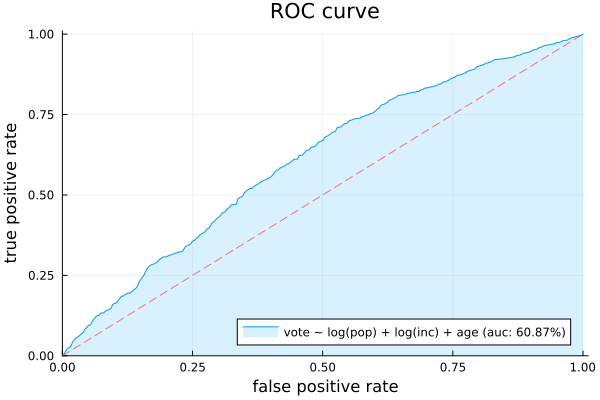

In [33]:
rocplot(chile.voteyes, 
    predict(modlog4), 
    label = "vote ~ log(pop) + log(inc) + age", 
    diagonal = true)

## Why not run a Linear Regression?

You could ask this very valid question. And my answer here differs a bit from the book.

**Suggestion 01:**

If you want to **measure a treatment effect**, or any other fitting where **explanation trumps prediction**, go with the linear regression.
- Easy to explain to a lay audience.

- Good polynomial expansion around the ATE.

- But there is a need for a careful design (in Causal Inference, the design is more important than the statistical method!).

- Interaction terms are just partial derivatives of the fitted equation (no partial of the link function using chain rule).

## Why not run a Linear Regression?

**Suggestion 02:**

If you want to **predict outcomes**, go with a classification model appropriate for your target variable unit.

- You are not going to do `weird` prediction.

- You have a marginal efficiency gain (in terms of Standard Errors).

- If you have an ordered target variable, your model does *look like more meaningful*.

- You should be careful when interpreting interaction terms.

## Why not run a Linear Regression?

**Suggestion 03:**

Be **careful when you have discrete nominal variation in your target variable**:

- Binary outcome: Linear Regression and Linear Discriminant Analysis are the same.

- Three or more categories, like the `vote` in the Chilean dataset messes up badly with things.

# Questions?

# See you next class
